<div style="background-color: #8e7cc3; padding: 7px; text-align: center;">
    <h2>Projeto Machine Learning I | Problema de Classificação com KNN e Random Forest</h2>
</div>

#### Grupo:
- Matheus Mendonça Lopes (1116008)
- Otávio Teixeira Santos (1116014)
- Tainah Guerra Santos (1116005)

## Decrição

**Objetivo:**

**Dados:**

| Atributo                    | Descrição                                      | 
|-----------------------------|------------------------------------------------|
| Age                         | Idade do paciente (anos) |
| Sex                         | Sexo do paciente (M: Masculino, F: Feminino)                               |
| ChestPainType               | Tipo de dor no peito (TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não-Anginosa, ASY: Assintomático) |
| RestingBP                   | Pressão arterial em repouso (mm Hg) | 
| Cholesterol                 | Colesterol sérico (mm/dl) | 
| FastingBS                   | Açúcar no sangue em jejum (1: se FastingBS > 120 mg/dl, 0: caso contrário) | 
| RestingECG                  | Resultados do eletrocardiograma em repouso (Normal: Normal, ST: anormalidade de onda ST-T, LVH: mostrando hipertrofia ventricular esquerda provável ou definitiva) |
| MaxHR                       | Frequência cardíaca máxima alcançada (60-202) | 
| ExerciseAngina              | Angina induzida por exercício (Y: Sim, N: Não) | 
| Oldpeak                     | Valor do Oldpeak = ST |                         
| ST_Slope                    | Inclinação do segmento ST no pico do exercício (Up: inclinação ascendente, Flat: plana, Down: inclinação descendente)| 
| HeartDisease                | Classe de saída (1: Doença Cardíaca, 0: Normal) | 


## Importando Bibliotecas

In [62]:
# Manipulação dos dados

import pandas as pd
import numpy as np

# DataViz

import seaborn as sns
import matplotlib.pyplot as plt

# Split dos dados

from sklearn.model_selection import train_test_split

# Transformação

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Métricas

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_curve


# Modelagem

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


## Análise Exploratória dos Dados

In [32]:
# Carregando dados

data = pd.read_csv('data/heart.csv')

In [33]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [35]:
data.duplicated().sum()

0

In [36]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [76]:
def create_roc_curve(y_pred, model_name):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot(color='purple')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curva ROC {model_name}')
    plt.show()

In [80]:
def create_conf_matrix(y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Doença Cardíaca'])
    cm_display.plot(cmap=plt.cm.Purples)
    plt.title(f'Matriz de Confusão {model_name}')
    plt.show()

## Pré-processamento

Para melhor funcionamento dos algoritmos, é importante converter dados categóricos em formato de string para valores númericos.

In [37]:
def transform_dataset(df, onehot_encoder, cat_variables):

    dummy_variables_df = pd.DataFrame(
        data = onehot_encoder.transform(df[cat_variables]).toarray(),
        columns = onehot_encoder.get_feature_names_out(),
        index = df.index
    )
    df = pd.concat([
        df.drop(columns = cat_variables),
        dummy_variables_df
    ], axis = 1)

    return df

In [38]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
col = list(X.columns)
categorical_features = []
for i in col:
    if len(data[i].unique()) <= 6:
        categorical_features.append(i)

In [40]:
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X_train[categorical_features])

OneHotEncoder()

In [41]:
X_train = transform_dataset(
    X_train, one_hot_encoder, categorical_features
)

X_test = transform_dataset(
    X_test, one_hot_encoder, categorical_features
)

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelo KNN

In [48]:
from scipy.stats import randint

knn_parameters = {'n_neighbors': randint(1,30)}

knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, param_distributions=knn_parameters, n_iter=20, cv=5)

knn_random_search.fit(X_train, y_train)

best_knn_params = knn_random_search.best_params_
best_knn_model = knn_random_search.best_estimator_

print('Melhores hiperparâmetros para KNN: ', best_knn_params)

Melhores hiperparâmetros para KNN:  {'n_neighbors': 16}


In [59]:
y_pred_knn = best_knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)

print(f"Accuracy KNN: {accuracy:.2f}")
print(f"Precision KNN: {precision:.2f}")
print(f"Recall KNN: {recall:.2f}")

Accuracy KNN: 0.85
Precision KNN: 0.88
Recall KNN: 0.86


<Figure size 800x600 with 0 Axes>

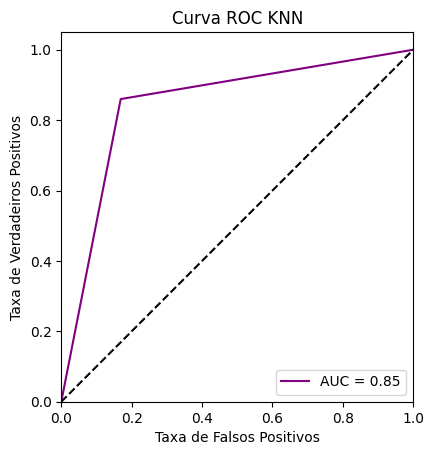

In [77]:
create_roc_curve(y_pred_knn, 'KNN')

<Figure size 800x600 with 0 Axes>

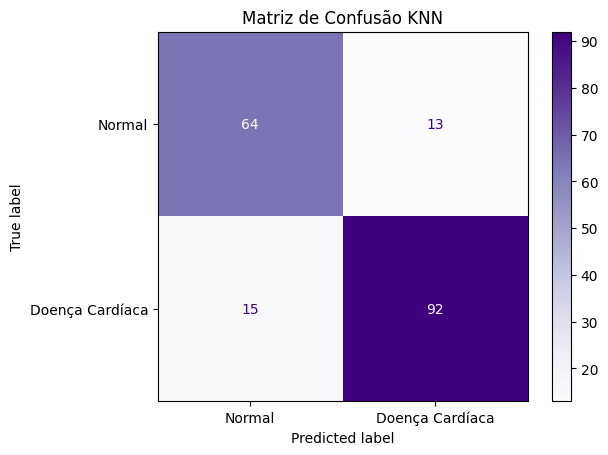

In [81]:
create_conf_matrix(y_pred_knn, 'KNN')

## Modelo Random Forest

In [50]:
rf_parameters = {'n_estimators': randint(50,500),
                'max_depth': randint(1,20),
                'min_samples_split': randint(2, 10),  
                'min_samples_leaf': randint(1, 5)}

rf = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_parameters, n_iter=20, cv=5)

rf_random_search.fit(X_train, y_train)

best_rf_params = rf_random_search.best_params_
best_rf_model = rf_random_search.best_estimator_

print('Melhores hiperparâmetros para Random Forest: ', best_rf_params)

Melhores hiperparâmetros para Random Forest:  {'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 394}


In [58]:
y_pred_rf = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)

print(f"Accuracy Random Forest: {accuracy:.2f}")
print(f"Precision Random Forest: {precision:.2f}")
print(f"Recall Random Forest: {recall:.2f}")

Accuracy Random Forest: 0.89
Precision Random Forest: 0.89
Recall Random Forest: 0.93


<Figure size 800x600 with 0 Axes>

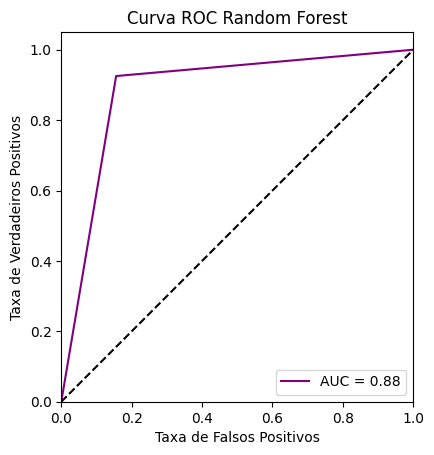

In [82]:
create_roc_curve(y_pred_rf, 'Random Forest')

<Figure size 800x600 with 0 Axes>

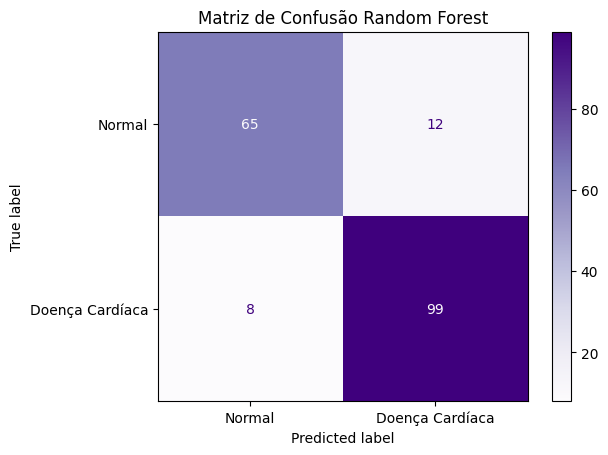

In [83]:
create_conf_matrix(y_pred_rf, 'Random Forest')

## Conclusão